In [11]:
import numpy as np
import skvideo.io
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 42})
import os
import textwrap
import csv
import json
import re
import cv2
import json
import seaborn as sns
import pandas as pd

# Analysis for networks written in keras (improved and arch_search siamese)

In [12]:
def sort_by_digits(unsorted_list):
    convert = lambda text: float(text) if text.isdigit() else text
    alphanum = lambda key: [convert(c) for c in re.split('([-+]?[0-9]*\.?[0-9]*)', key)]
    unsorted_list.sort(key=alphanum)
    return unsorted_list

In [13]:
def extract_subdirs(main_dir, include_pattern, exclude_folder, exclude_pattern=None):
    valid_subdirs = []
    for subdir in os.listdir(main_dir):
        full_subdir = os.path.join(main_dir, subdir)
        if exclude_pattern:
            if (os.path.isdir(full_subdir) 
                and include_pattern in str(full_subdir)
                and exclude_pattern not in str(full_subdir)
                and str(full_subdir) != exclude_folder):
                valid_subdirs.append(full_subdir)
        else:
             if (os.path.isdir(full_subdir) 
                and include_pattern in str(full_subdir)
                and str(full_subdir) != exclude_folder):
                valid_subdirs.append(full_subdir)
    return valid_subdirs

In [14]:
def extract_metadata(exp_folder):
    exp_file = os.path.join(exp_folder, "experiment_details.json")
    with open(exp_file) as json_file:  
        data = json.load(json_file)
    return data  

In [15]:
def make_accuracy_lists(curr_dir, csv_file_name):
    epoch_dirs = sort_by_digits(extract_subdirs(curr_dir, "epoch_", "", None))
    siamese_train_loss = [] 
    siamese_train_acc = [] 
    siamese_val_acc = []
    siamese_test_acc = []
    classif_right = []
    classif_left = []
    for i, ep_dir in enumerate(epoch_dirs):
        dir_name = ep_dir.split("/")[-1]
        acc_file = os.path.join(ep_dir, "{}_{}.csv".format(csv_file_name, dir_name))
        with open(acc_file) as csvfile:
            reader = list(csv.DictReader(csvfile))
            siamese_train_loss.append(round(float(reader[0]["siamese_loss"]), 2))
            siamese_train_acc.append(round(float(reader[0]["siamese_acc"])*100, 2))
            siamese_val_acc.append(round(float(reader[0]["siamese_val_accuracy"])*100, 2))
            siamese_test_acc.append(round(float(reader[0]["siamese_test_accuracy"])*100, 2))
            classif_left.append(round(float(reader[0]["left_acc"])*100, 2))
            classif_right.append(round(float(reader[0]["right_acc"])*100, 2))
    return siamese_train_loss, siamese_train_acc, siamese_val_acc, siamese_test_acc, classif_left, classif_right

In [16]:
def get_exp_results(res_dir, with_classif):
    network_type = []
    dataset = []
    optimizer = []
    seed = []
    max_test_acc = []
    max_val_acc = []
    max_train_acc = []
    left_classif_acc = []
    right_classif_acc = []
    runs = []
    for experiment in res_dir:
        run = experiment.split("/")[-1]
        metadata = extract_metadata(experiment)
        siamese_train_loss, siamese_train_acc,\
            siamese_val_acc, siamese_test_acc,\
            left_classif, right_classif = make_accuracy_lists(experiment, "metrics")
        network_type.append(metadata["model"])
        dataset.append(metadata["dataset"])
        optimizer.append(metadata["optimizer"])
        seed.append(metadata["seed"])
        runs.append(run)
        max_test_acc.append(np.amax(siamese_test_acc))
        max_val_acc.append(np.amax(siamese_val_acc))
        max_train_acc.append(np.amax(siamese_train_acc))
        left_classif_acc.append(np.amax(left_classif))
        right_classif_acc.append(np.amax(right_classif))

    df = pd.DataFrame({"net_type": network_type,
                       "dataset": dataset,
                       "optimizer": optimizer,
                       "seed": seed,
                       "max_test_acc": max_test_acc,
                       "max_val_acc": max_val_acc,
                       "max_train_acc": max_train_acc,
                       "left_classif_acc":left_classif_acc,
                       "right_classif_acc":right_classif_acc,
                       "folder": runs,
                       "with_classif": [with_classif] * len(runs)})
    df = df[(df["optimizer"]=="sgd") & (df["net_type"].isin(["OriginalNetworkV2",
                                                               "OriginalNetworkV3",
                                                               "HorizontalNetworkV5",
                                                               "HorizontalNetworkV7",
                                                               "HorizontalNetworkV8",
                                                               "HorizontalNetworkV9",
                                                               "HorizontalNetworkV10",
                                                               "HorizontalNetworkV11",
                                                               "HorizontalNetworkV12",
                                                               "WideNetwork"]))]
    corrections = {"OriginalNetworkV2":"S-subtract",
                   "OriginalNetworkV3":"S-concat",
                   "HorizontalNetworkV5":"S-multires",
                   "HorizontalNetworkV7":"S-multires-A9",
                   "HorizontalNetworkV8":"S-multires-A7",
                   "HorizontalNetworkV9":"S-multires-A5",
                   "HorizontalNetworkV10":"S-multires-A3",
                   "HorizontalNetworkV11":"S-multires-R9",
                   "HorizontalNetworkV12":"S-multires-R3",
                   "WideNetwork":"Wide Resnet"}
    df.net_type = df.net_type.map(corrections)
    return df

In [17]:
# classification and siamese training together
results_dirs_1 = extract_subdirs("/mnt/data/siamese_cluster_new/results/results_with_classif",
                                 "", "", None)
results_dirs_2 = extract_subdirs("/mnt/data/siamese_cluster_new/results/results_without_classif",
                                 "", "", None)
results_dirs_3 = extract_subdirs("/mnt/data/siamese_cluster_new/results/results_without_siamese",
                                 "", "", None)

In [18]:
siamclassif_df = get_exp_results(results_dirs_1, "yes")

/home/iulialexandra/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [19]:
siamclassif_df.groupby(["dataset", "net_type"]).mean()

seed  max_test_acc  max_val_acc  \
dataset       net_type                                             
cifar100      S-concat       5.500000     50.500000    68.490000   
              S-multires     4.750000     53.558333    67.591667   
              S-subtract     5.500000     49.680000    65.510000   
              Wide Resnet    2.500000     42.475000    52.050000   
omniglot      S-concat       5.500000     95.030000    96.970000   
              S-multires     5.666667     99.011111    99.600000   
              S-subtract     5.500000     97.000000    98.770000   
roshambo      S-concat       5.500000     58.920000    69.620000   
              S-multires     5.285714     62.814286    70.338095   
              S-multires-A3  5.500000     65.940000    68.030000   
              S-multires-A9  5.500000     63.290000    70.160000   
              S-multires-R3  5.500000     62.190000    69.930000   
              S-multires-R9  5.000000     65.088889    71.766667   
              S-subtract     5.500000     58.010000    71.680000   
              Wide Resnet    5.500000     54.570000    58.700000   
tiny-imagenet S-concat       5.500000     49.980000    58.600000   
              S-multires     5.200000     54.930000    62.050000   
              S-multires-A3  5.500000     54.820000    60.120000   
              S-multires-A5  5.000000     54.933333    61.011111   
              S-multires-A7  5.500000     54.790000    60.520000   
              S-multires-A9  5.500000     53.020000    60.130000   
              S-multires-R3  5.500000     53.470000    58.510000   
              S-multires-R9  5.500000     53.490000    58.170000   
              S-subtract     5.500000     49.710000    55.410000   
              Wide Resnet    1.500000     53.150000    63.950000   

                             max_train_acc  left_classif_acc  \
dataset       net_type                                         
cifar100      S-concat           85.929000         80.277000   
              S-multires         90.526667         95.438333   
              S-subtract         76.544000         73.535000   
              Wide Resnet        97.930000         98.865000   
omniglot      S-concat           99.403000         99.839000   
              S-multires         99.106667         99.986667   
              S-subtract         97.757000         99.032000   
roshambo      S-concat           98.918000         98.251000   
              S-multires        100.000000        100.000000   
              S-multires-A3     100.000000        100.000000   
              S-multires-A9     100.000000        100.000000   
              S-multires-R3     100.000000        100.000000   
              S-multires-R9     100.000000        100.000000   
              S-subtract         98.142000         97.867000   
              Wide Resnet        99.982000         99.981000   
tiny-imagenet S-concat           91.515000         97.667000   
              S-multires         79.391000         93.257000   
              S-multires-A3      78.499000         92.556000   
              S-multires-A5      78.937778         92.872222   
              S-multires-A7      79.531000         92.974000   
              S-multires-A9      79.674000         92.789000   
              S-multires-R3      78.148000         90.052000   
              S-multires-R9      77.993000         89.971000   
              S-subtract         71.090000         97.485000   
              Wide Resnet        89.920000         96.410000   

                             right_classif_acc  
dataset       net_type                          
cifar100      S-concat               80.162000  
              S-multires             92.445833  
              S-subtract             73.334000  
              Wide Resnet            95.665000  
omniglot      S-concat               99.835000  
              S-multires             99.891111  
              S-subtract             98.908000  
roshambo      S-concat    

# Plots with classification and similarity

In [21]:
ablation_df = siamclassif_df[siamclassif_df["dataset"]=="tiny-imagenet"]

In [22]:
ablation_df

,net_type,dataset,optimizer,seed,max_test_acc,max_val_acc,max_train_acc,left_classif_acc,right_classif_acc,folder,with_classif
0,S-multires-R9,tiny-imagenet,sgd,8,47.8,45.7,78.60,89.86,76.81,2019_9_25-11_58_32_845899_seed_8_tiny-imagenet...,yes
2,S-multires,tiny-imagenet,sgd,2,61.3,63.8,79.24,93.57,83.68,2019_9_1-14_30_43_651064_seed_2_tiny-imagenet_...,yes
5,S-multires-A3,tiny-imagenet,sgd,7,58.6,66.3,78.52,93.08,77.72,2019_9_26-4_16_9_597313_seed_7_tiny-imagenet_H...,yes
10,S-subtract,tiny-imagenet,sgd,4,41.3,48.5,70.49,97.32,97.27,2019_10_27-6_26_17_181390_seed_4_tiny-imagenet...,yes
26,S-multires-R3,tiny-imagenet,sgd,2,60.4,63.9,78.16,90.58,79.10,2019_9_26-1_13_10_500558_seed_2_tiny-imagenet_...,yes
27,S-concat,tiny-imagenet,sgd,10,52.5,56.5,91.85,97.82,97.76,2019_10_26-16_15_25_188713_seed_10_tiny-imagen...,yes
30,S-multires-R9,tiny-imagenet,sgd,10,56.9,51.7,77.71,90.54,76.79,2019_9_25-11_58_32_846055_seed_10_tiny-imagene...,yes
31,S-multires-A3,tiny-imagenet,sgd,10,54.2,53.2,78.37,93.23,77.92,2019_9_26-9_37_31_417315_seed_10_tiny-imagenet...,yes
36,S-concat,tiny-imagenet,sgd,7,56.2,65.1,91.48,97.62,97.70,2019_10_26-12_29_22_551878_seed_7_tiny-imagene...,yes
43,S-multires-A5,tiny-imagenet,sgd,6,60.9,72.3,78.55,92.47,80.90,2019_9_26-9_38_7_244658_seed_6_tiny-imagenet_H...,yes


In [23]:
def plot_boxplots(plots_path, df, which_acc, ylabel, figure_name):
    sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth":2.0, "grid.linewidth":2.0})
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(30, 20)
    sns.boxplot(x="net_type", y=which_acc, color="grey", linewidth=4, data=df, ax=ax,
               order=["S-subtract",
                    "S-concat",
                    "S-multires",
                    "S-multires-A9",
                    "S-multires-A3",
                    "S-multires-R9",
                    "S-multires-R3"])
    ax.set_xticklabels([textwrap.fill(t.get_text(), 10)  for t in ax.get_xticklabels()])
    sns.despine(left=True, bottom=True)
    ax.set_xlabel("")
    ax.set_ylabel(ylabel, labelpad=20)
    fig.savefig(os.path.join(plots_path, figure_name), bbox_inches='tight', dpi=100)

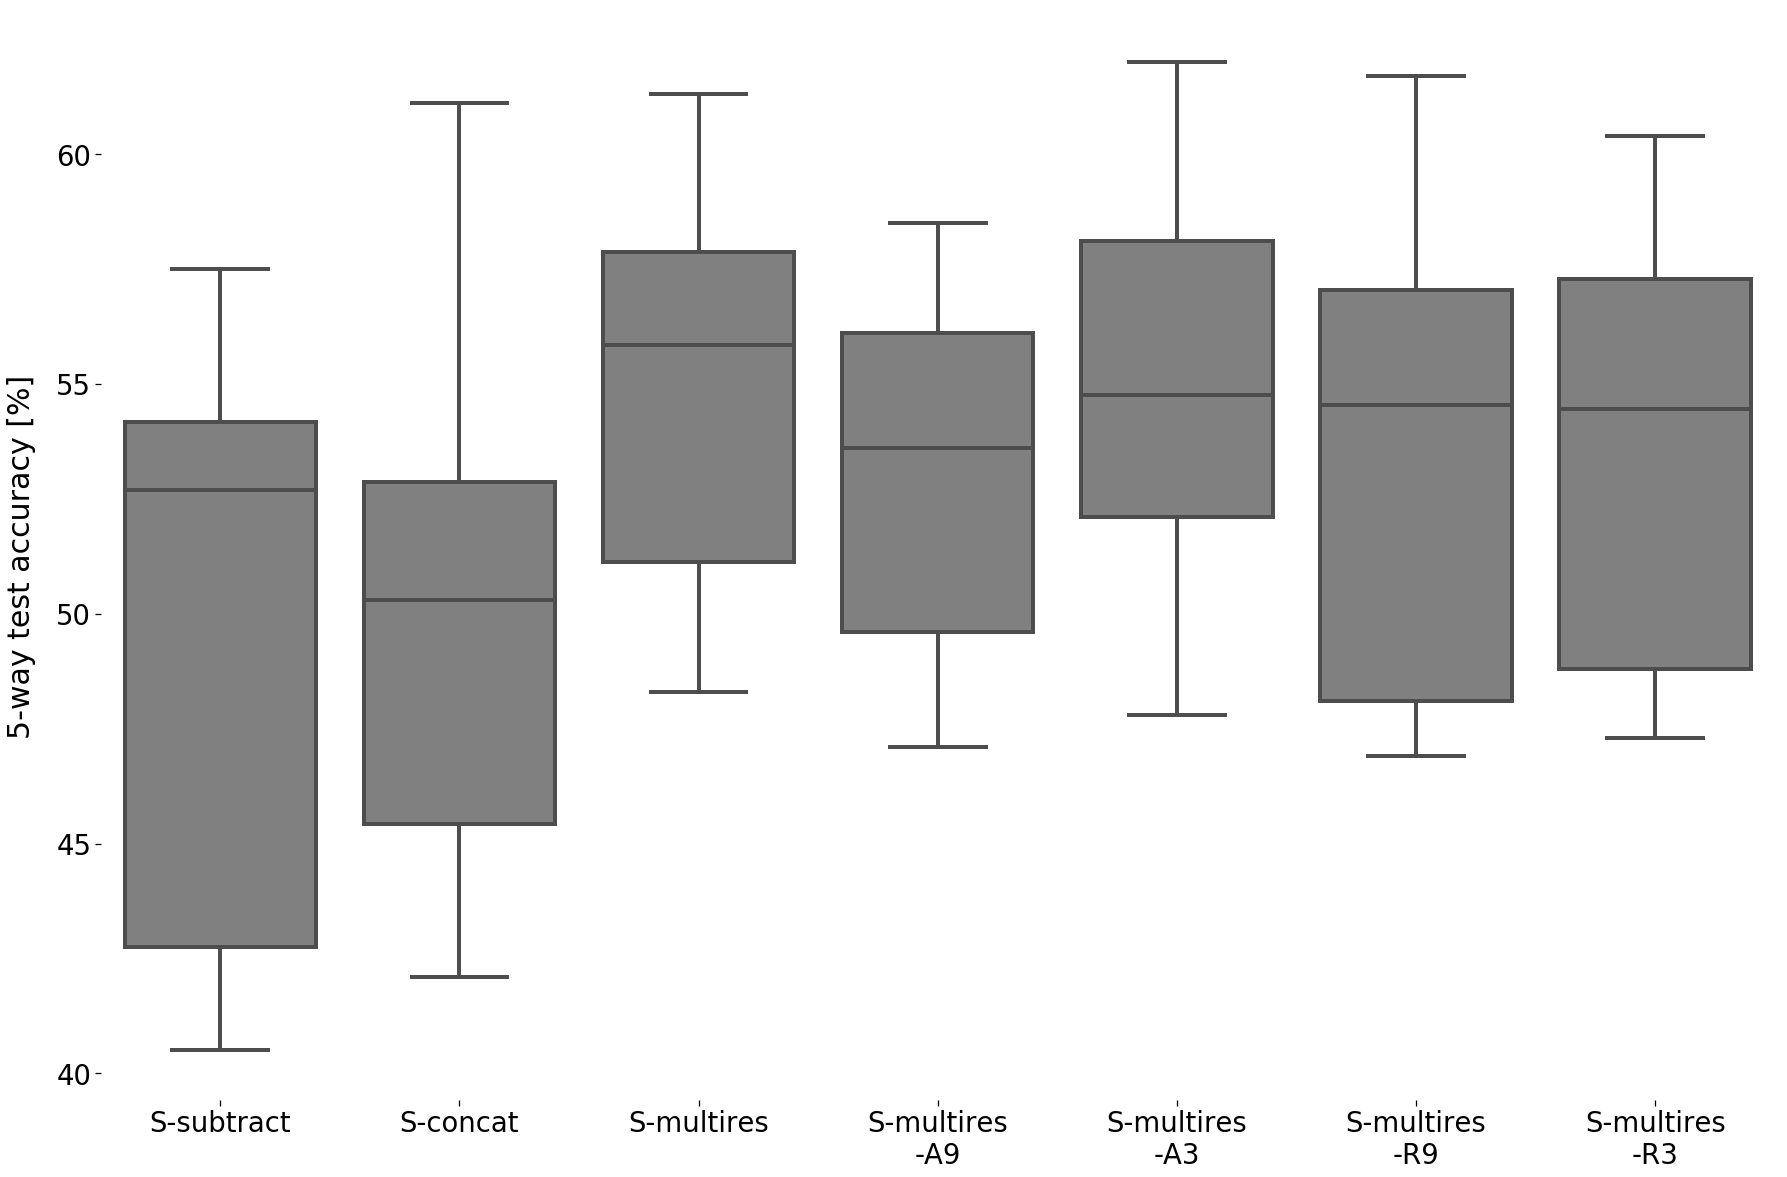

In [24]:
plot_boxplots("/mnt/Storage/code/low-shot/figures", ablation_df, "max_test_acc",
              "5-way test accuracy [%]", "ablation_study")

In [25]:
ablation_df.groupby(["net_type"]).mean()

,seed,max_test_acc,max_val_acc,max_train_acc,left_classif_acc,right_classif_acc
net_type,,,,,,
S-concat,5.5,49.980000,58.600000,91.515000,97.667000,97.676000
S-multires,5.2,54.930000,62.050000,79.391000,93.257000,83.273000
S-multires-A3,5.5,54.820000,60.120000,78.499000,92.556000,77.588000
S-multires-A5,5.0,54.933333,61.011111,78.937778,92.872222,81.164444
S-multires-A7,5.5,54.790000,60.520000,79.531000,92.974000,83.537000
S-multires-A9,5.5,53.020000,60.130000,79.674000,92.789000,84.357000
S-multires-R3,5.5,53.470000,58.510000,78.148000,90.052000,78.702000
S-multires-R9,5.5,53.490000,58.170000,77.993000,89.971000,76.678000
S-subtract,5.5,49.710000,55.410000,71.090000,97.485000,97.419000


# Violin plots with and without classification

In [35]:
def plot_violins(plots_path, res_df, which_acc):
    unique_datasets = res_df["dataset"].unique()
    sns.set_context("notebook", font_scale=3.5, rc={"lines.linewidth":2.0, "grid.linewidth":2.0})
    for dataset in unique_datasets:
        print(dataset)
        figure_name = dataset + "_" + which_acc
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(30, 20)
        dataset_df = res_df[res_df["dataset"]==dataset]        
        sns.violinplot(x="net_type", y=which_acc, hue="with_classif",
                       split=True, linewidth=4, inner="quart",
                       palette={"No classification": "white", "With classification": "gray"},
                       data=dataset_df, ax=ax,
                       order=["S-subtract",
                              "S-concat",
                              "S-multires"])
        plt.legend(loc='upper left')
        ax.set_xticklabels([textwrap.fill(t.get_text(), 12)  for t in ax.get_xticklabels()])
        sns.despine(left=True, bottom=True)
        ax.set_xlabel("")
        ax.set_ylabel("5-way test accuracy [%] {}".format(dataset), labelpad=20)
        fig.savefig(os.path.join(plots_path, figure_name), bbox_inches='tight', dpi=100)

In [36]:
without_df = get_exp_results(results_dirs_2, "No classification")
with_df = get_exp_results(results_dirs_1, "With classification")
complete_df = pd.concat([with_df, without_df])
complete_df = complete_df.reset_index(drop=True)

/home/iulialexandra/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [40]:
with_df.groupby(["dataset", "net_type"]).mean()

seed  max_test_acc  max_val_acc  \
dataset       net_type                                             
cifar100      S-concat       5.500000     50.500000    68.490000   
              S-multires     4.750000     53.558333    67.591667   
              S-subtract     5.500000     49.680000    65.510000   
              Wide Resnet    2.500000     42.475000    52.050000   
omniglot      S-concat       5.500000     95.030000    96.970000   
              S-multires     5.666667     99.011111    99.600000   
              S-subtract     5.500000     97.000000    98.770000   
roshambo      S-concat       5.500000     58.920000    69.620000   
              S-multires     5.285714     62.814286    70.338095   
              S-multires-A3  5.500000     65.940000    68.030000   
              S-multires-A9  5.500000     63.290000    70.160000   
              S-multires-R3  5.500000     62.190000    69.930000   
              S-multires-R9  5.000000     65.088889    71.766667   
              S-subtract     5.500000     58.010000    71.680000   
              Wide Resnet    5.500000     54.570000    58.700000   
tiny-imagenet S-concat       5.500000     49.980000    58.600000   
              S-multires     5.200000     54.930000    62.050000   
              S-multires-A3  5.500000     54.820000    60.120000   
              S-multires-A5  5.000000     54.933333    61.011111   
              S-multires-A7  5.500000     54.790000    60.520000   
              S-multires-A9  5.500000     53.020000    60.130000   
              S-multires-R3  5.500000     53.470000    58.510000   
              S-multires-R9  5.500000     53.490000    58.170000   
              S-subtract     5.500000     49.710000    55.410000   
              Wide Resnet    1.500000     53.150000    63.950000   

                             max_train_acc  left_classif_acc  \
dataset       net_type                                         
cifar100      S-concat           85.929000         80.277000   
              S-multires         90.526667         95.438333   
              S-subtract         76.544000         73.535000   
              Wide Resnet        97.930000         98.865000   
omniglot      S-concat           99.403000         99.839000   
              S-multires         99.106667         99.986667   
              S-subtract         97.757000         99.032000   
roshambo      S-concat           98.918000         98.251000   
              S-multires        100.000000        100.000000   
              S-multires-A3     100.000000        100.000000   
              S-multires-A9     100.000000        100.000000   
              S-multires-R3     100.000000        100.000000   
              S-multires-R9     100.000000        100.000000   
              S-subtract         98.142000         97.867000   
              Wide Resnet        99.982000         99.981000   
tiny-imagenet S-concat           91.515000         97.667000   
              S-multires         79.391000         93.257000   
              S-multires-A3      78.499000         92.556000   
              S-multires-A5      78.937778         92.872222   
              S-multires-A7      79.531000         92.974000   
              S-multires-A9      79.674000         92.789000   
              S-multires-R3      78.148000         90.052000   
              S-multires-R9      77.993000         89.971000   
              S-subtract         71.090000         97.485000   
              Wide Resnet        89.920000         96.410000   

                             right_classif_acc  
dataset       net_type                          
cifar100      S-concat               80.162000  
              S-multires             92.445833  
              S-subtract             73.334000  
              Wide Resnet            95.665000  
omniglot      S-concat               99.835000  
              S-multires             99.891111  
              S-subtract             98.908000  
roshambo      S-concat    

tiny-imagenet
roshambo
omniglot
cifar100


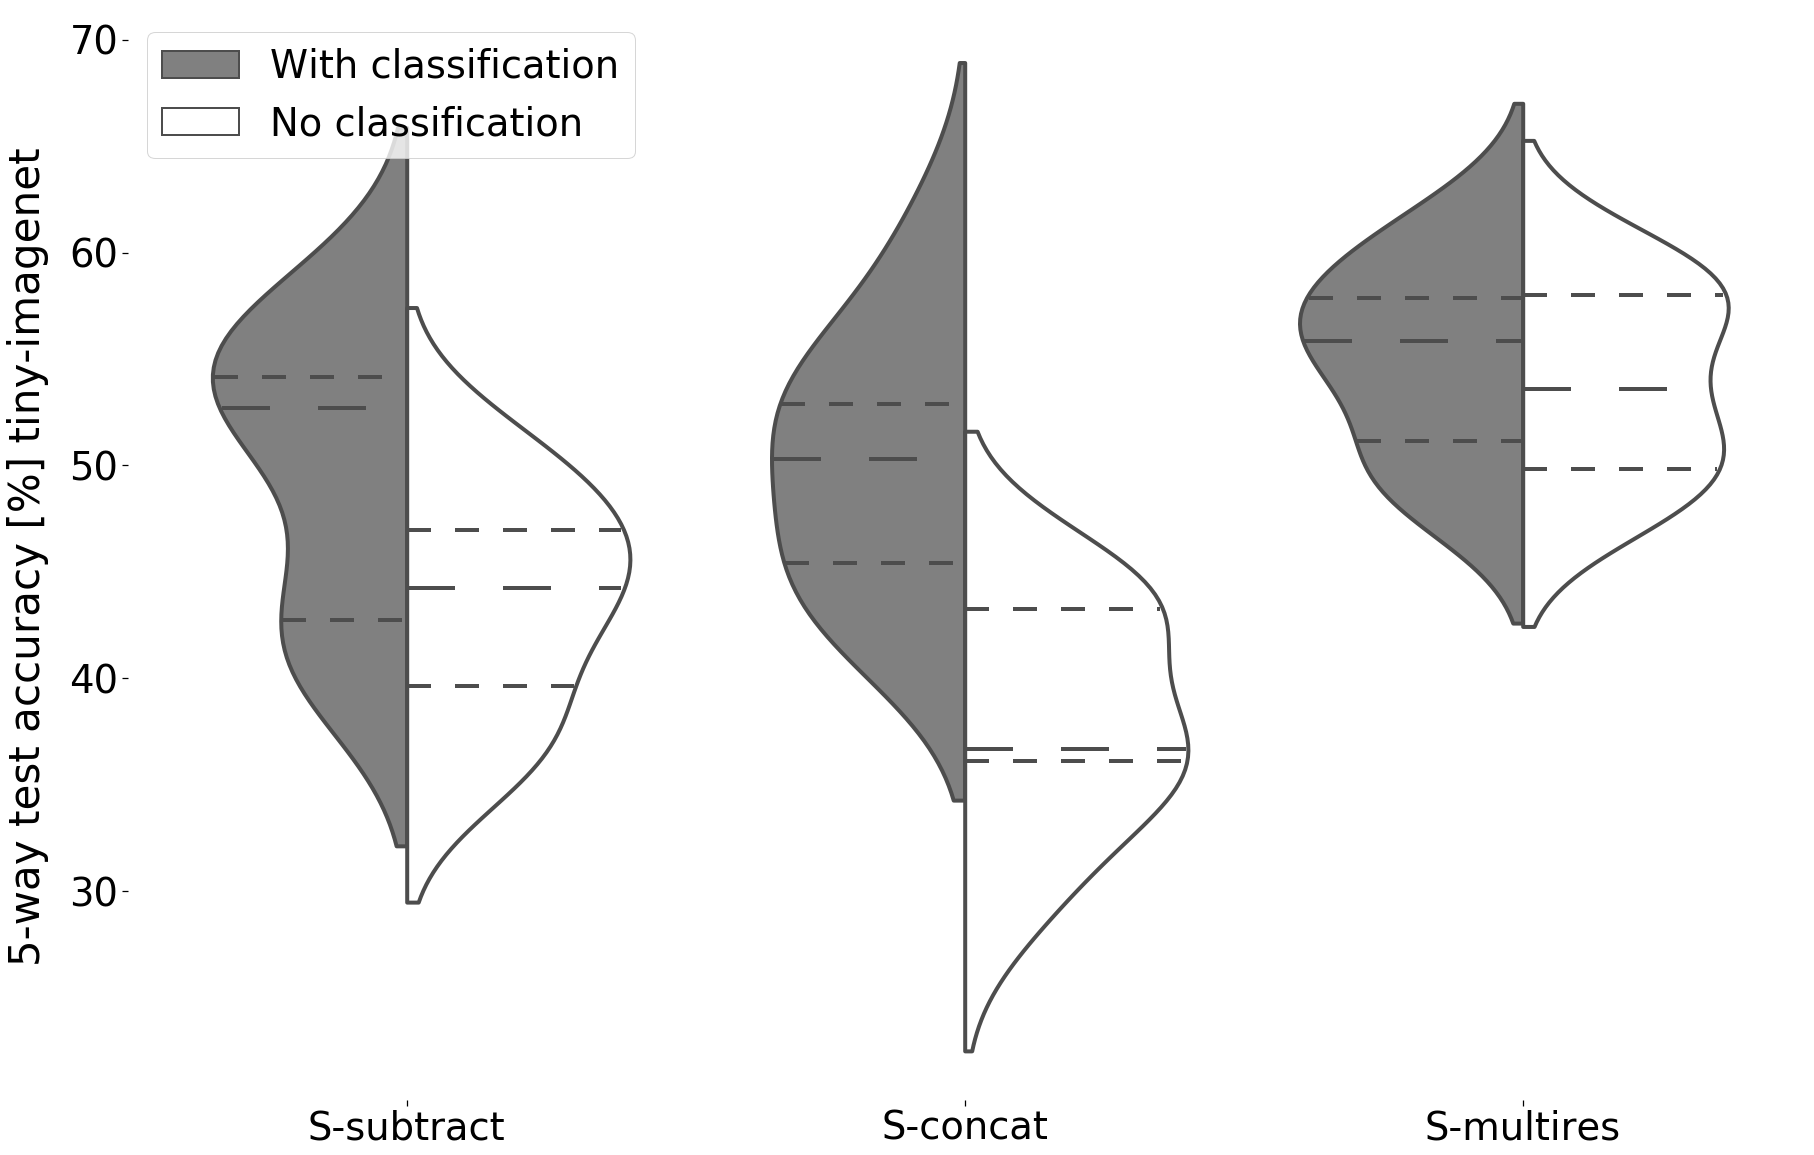

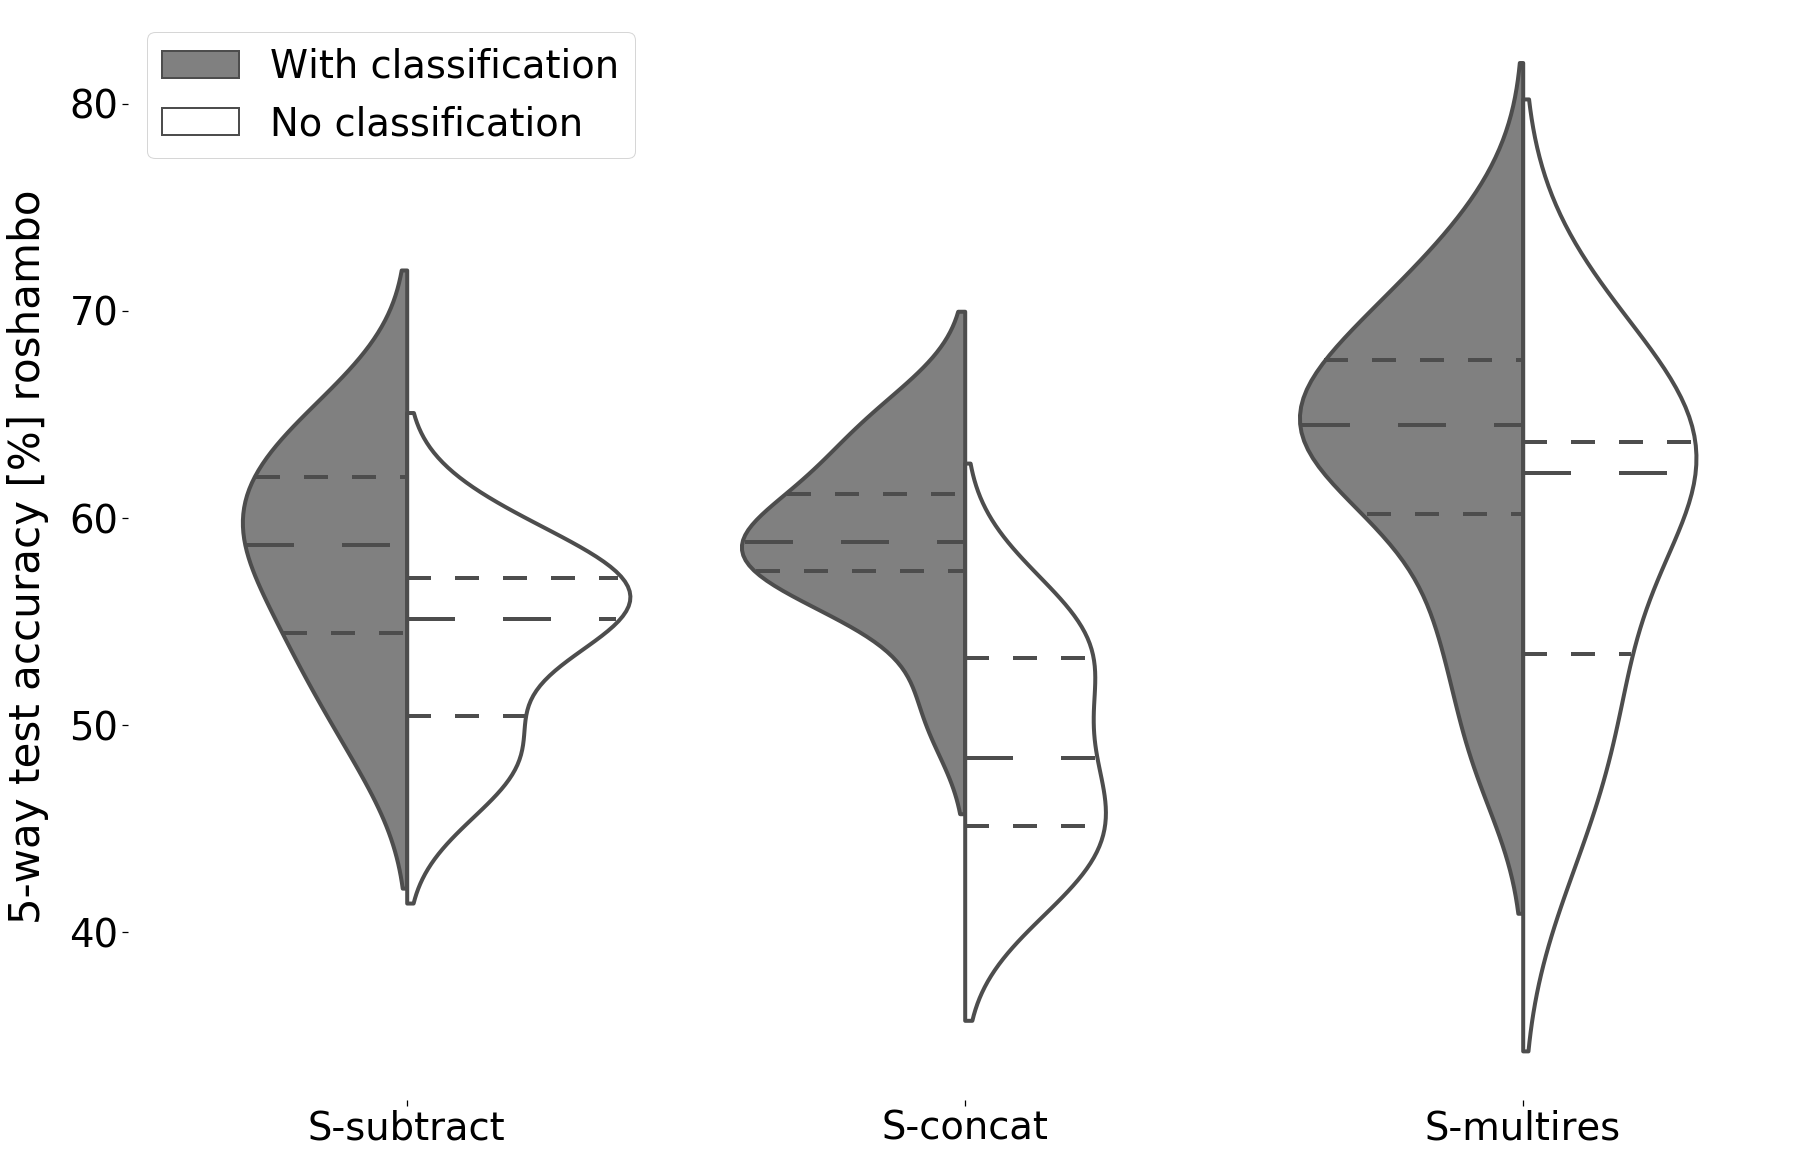

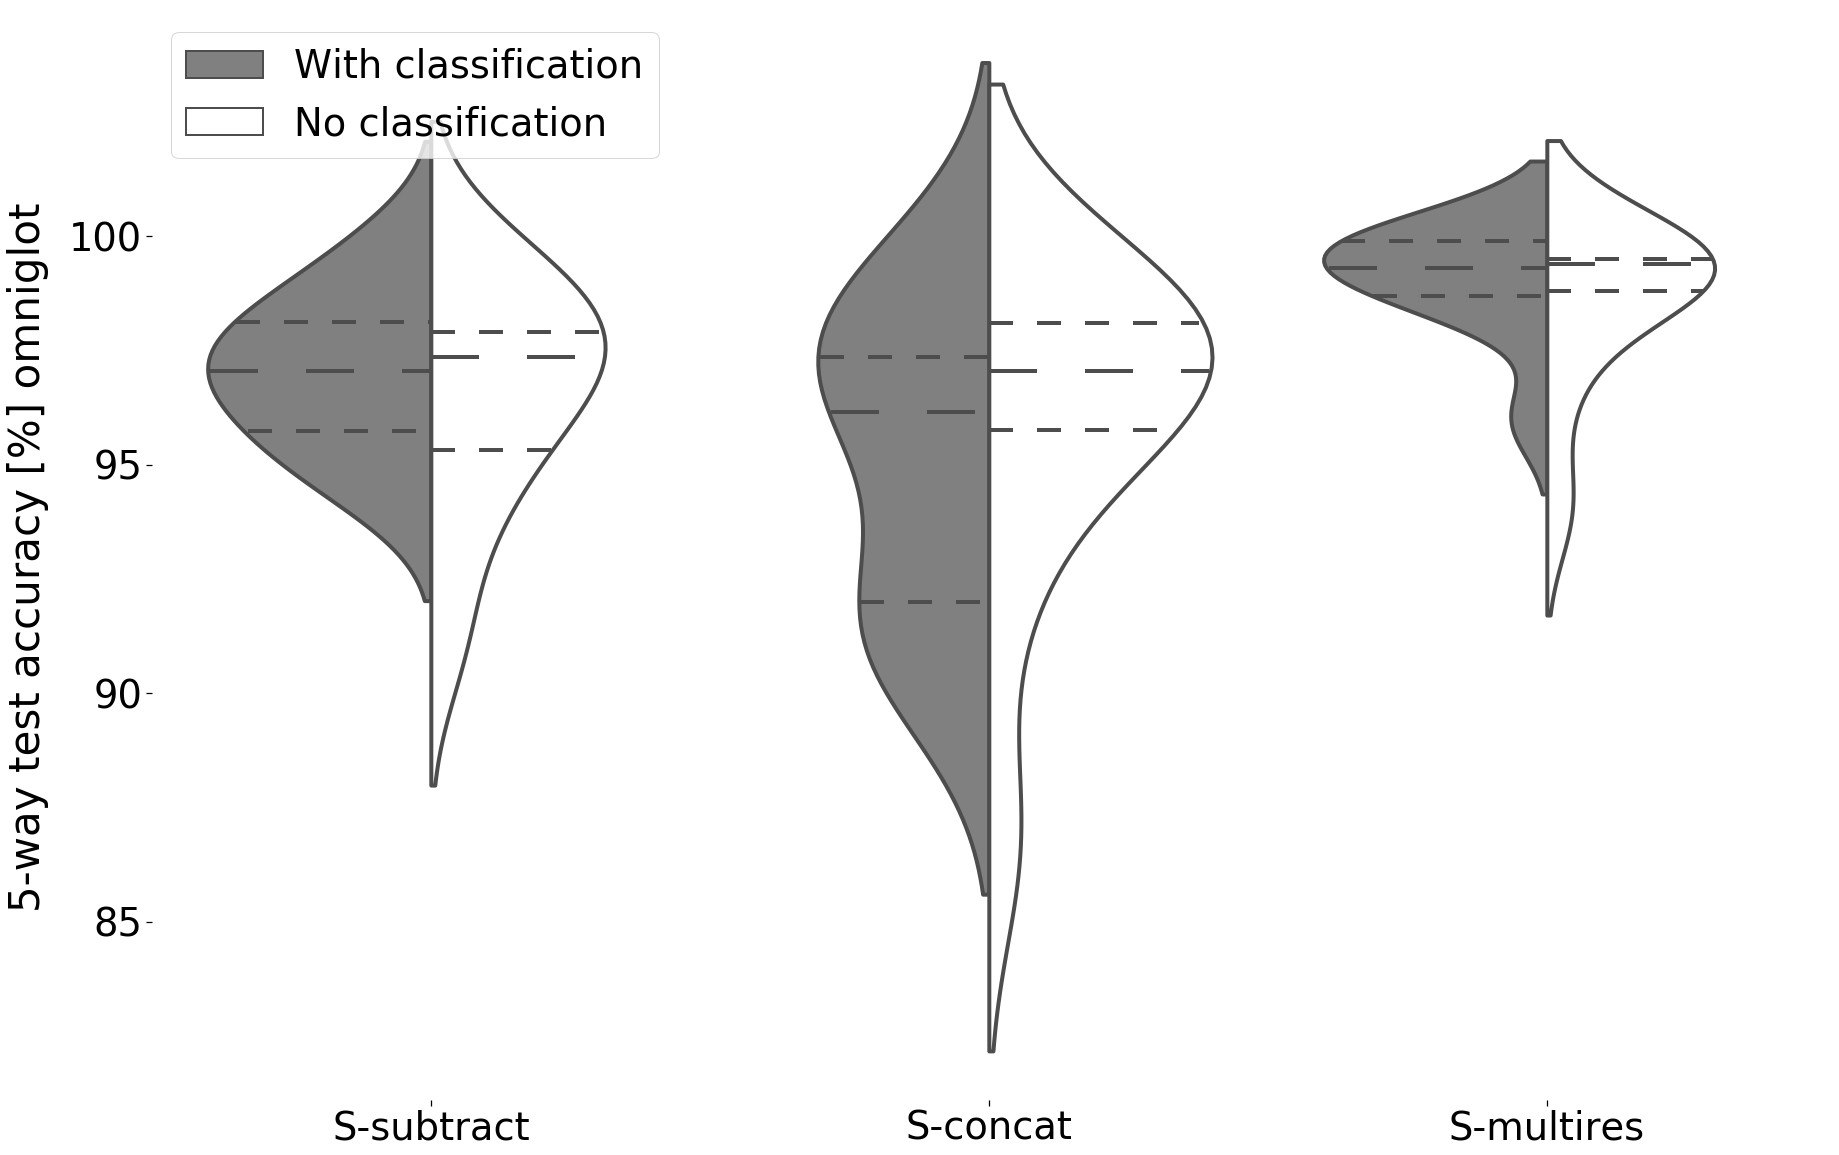

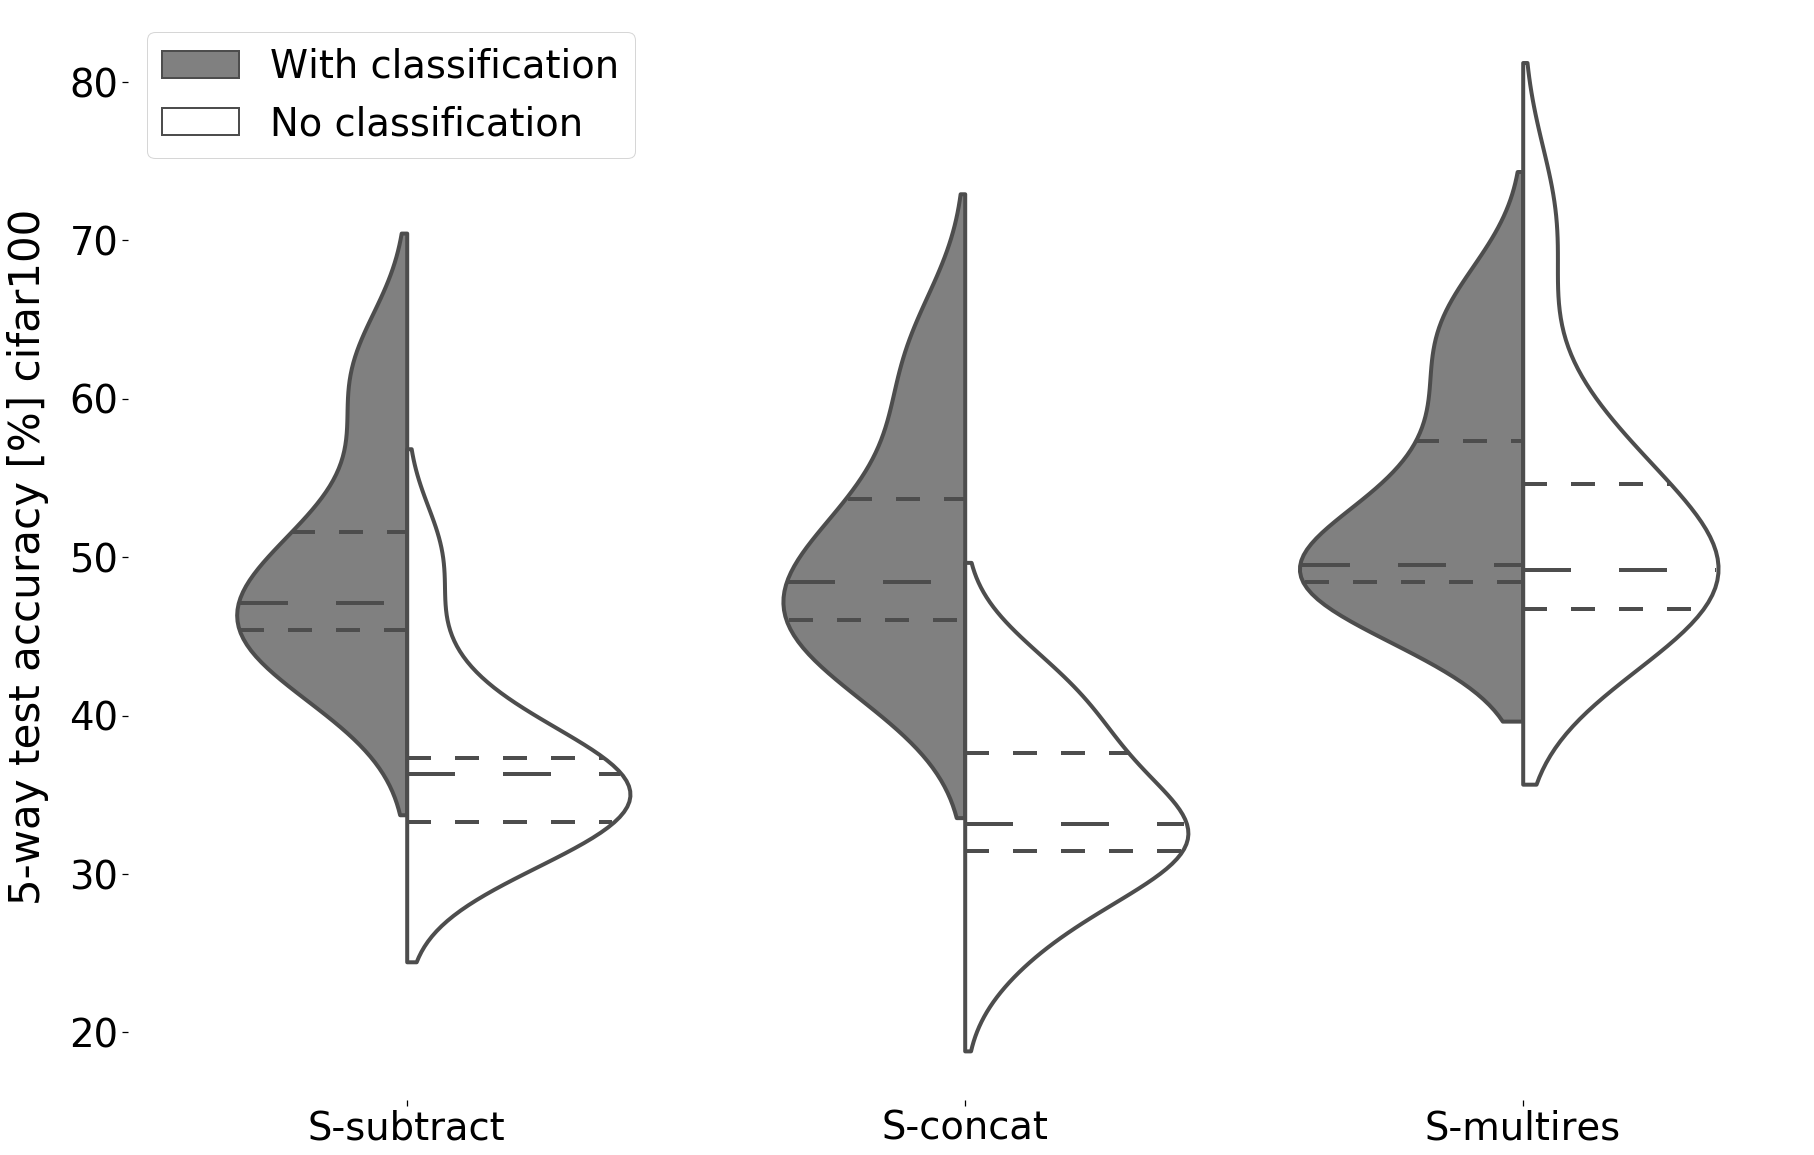

In [38]:
plot_violins("/mnt/Storage/code/low-shot/figures", complete_df, "max_test_acc")

In [ ]:
def plot_curves(plots_path, data, labels, figure_name, xlabel, ylabel, xticks=None, yticks=None):
    colors = ["black","red", "green", 'lightblue', '#FF9900', 'darkgreen', 
                '#F7E7BD',#cream
                'darkblue',
                '#55bb33', #greenish
                '#5533bb', #blueish
                '#cc3333',#reddish
                '#99ff99', #greenish
                '#9999ff', #blueish
                '#227722', #greenish
                '#222277', #blueish
                '#A4A28B',#olive
                '#B59A73',#coffee
                '#447799'
                ]
    linestyles = ['-', ':', '--', '-.']
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(25, 10)
    
    for idx, datum in enumerate(data):
        ax.plot(data[idx], c=colors[idx], linewidth=8, linestyle = linestyles[0],
            label=labels[idx], zorder=3)          
    ax.set_title(figure_name, fontsize=25)
    ax.set_xlabel(xlabel, fontsize=25)
    ax.set_ylabel(ylabel, fontsize=25)
    ax.tick_params(axis='both', which='minor', labelsize=25)
    ax.tick_params(axis='both', which='major', labelsize=25)
    if xticks is not None:
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(len(xticks)))
        ax.set_xticklabels(range(0, 200, 10))
    if yticks is not None:
        ax.yaxis.set_ticks_position('left')
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticks)
    ax.legend(loc='lower right', prop={'size':25.0}, frameon=True, fancybox=True)
    plt.grid(True)
#     ax.set_frame_on(True)
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)
    fig.savefig(os.path.join(plots_path, figure_name), bbox_inches='tight', dpi=300)

In [ ]:
def plot_all_experiment_curves(res_dir, xticks, yticks):
    for experiment in res_dir:
        run = experiment.split("/")[-1]
        metadata = extract_metadata(experiment)
        siamese_train_loss, siamese_train_acc,\
        siamese_val_acc, siamese_test_acc = make_accuracy_lists(experiment, "metrics")
        figure_name = (run + ":" + metadata["dataset"]
                       + "_" + metadata["model"]
                       + "_" + metadata["optimizer"]
                       + "_" + str(metadata["seed"]))
        labels = ["Training accuracy",
                  "Validation accuracy on {} {}-way tasks".format(metadata["n_val_tasks"],
                                                                  metadata["n_val_ways"]),
                  "Test accuracy on {} {}-way tasks".format(metadata["n_val_tasks"],
                                                                  metadata["n_val_ways"])]
        xlabel = "Epochs"
        ylabel = "Accuracy [%]"
        plot_curves(experiment, [siamese_train_acc, siamese_val_acc, siamese_test_acc],
                  labels, figure_name, xlabel, ylabel, xticks, yticks)

# Plot accuracy curves for "improved_siamese" - siamese and classification together

In [ ]:
xticks = range(0, 200, 5)
yticks = range(0, 110, 10)
plot_all_experiment_curves(results_dirs_1, xticks, yticks)

# Plot accuracy curves for "arch_search_siamese" - siamese metric learning alone

In [ ]:
xticks = range(0, 200, 10)
yticks = range(0, 110, 10)
plot_all_experiment_curves(results_dirs_2, xticks, yticks)

# Make video of siamese weights over epochs

In [ ]:
epochs_d = os.path.join(results_dir, epochs_dirs[0])
layers_dirs = sorted([name for name in os.listdir(epochs_d) if os.path.isdir
                     (os.path.join(epochs_d, name))])
print(layers_dirs)

In [ ]:
for idx, layer_dir in enumerate(layers_dirs):
    print("Processing video for layer {}".format(layer_dir))
    video_name = os.path.join(results_dir, '{}_weights.avi'.format(str(layer_dir)))
    layer_imgs = []
    for ep_img in epochs_dirs:
        layer_imgs.append(cv2.imread(os.path.join(results_dir, ep_img, layer_dir, "weights.png")))
    heights = [frame.shape[0] for frame in layer_imgs]
    widths = [frame.shape[1] for frame in layer_imgs]
    channels = [frame.shape[2] for frame in layer_imgs]

    height = min(heights)
    width = min(widths)
    images = [im[:height, :width, :] for im in layer_imgs]
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*"MJPG"), 1, (width, height))

    for image in images:
        video.write(np.array(image, dtype=np.uint8))
    video.release()

# Make video of feature maps over epochs

In [ ]:
for idx, layer_dir in enumerate(layers_dirs):
    print("Processing video for layer {}".format(layer_dir))
    video_name = os.path.join(results_dir, '{}_feature_maps.avi'.format(str(layer_dir)))
    layer_imgs = []
    for ep_img in epochs_dirs:
        layer_imgs.append(cv2.imread(os.path.join(results_dir, ep_img, layer_dir, "feature_maps.png")))

    heights = [frame.shape[0] for frame in layer_imgs]
    widths = [frame.shape[1] for frame in layer_imgs]
    channels = [frame.shape[2] for frame in layer_imgs]

    height = min(heights)
    width = min(widths)

    print(height)
    print(width)
    images = [im[:height, :width, :] for im in layer_imgs]
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*"MJPG"), 1, (width, height))

    for image in images:
        video.write(np.array(image, dtype=np.uint8))
    video.release()

# Plot predictions differences in the siamese networks

In [ ]:
for ep in epochs_dirs:
    print(ep)
    prediction_diffs = np.loadtxt(os.path.join(results_dir, "prediction_differences_{}.txt".format(ep)))
    plot_path = os.path.join(results_dir, "prediction_differences_{}.png".format(ep))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(25, 25)
    sns.distplot(prediction_diffs, ax=ax)
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.tick_params(axis='both', which='minor', labelsize=25)
    fig.savefig(plot_path, bbox_inches='tight', dpi=300)
    plt.close("all")


In [ ]:
video_name = os.path.join(results_dir, 'prediction_diffs.avi')
pred_diffs_imgs = []
for ep in epochs_dirs:
    pred_diffs_imgs.append(cv2.imread(os.path.join(results_dir,  "prediction_differences_{}.png".format(ep))))
    
heights = [frame.shape[0] for frame in pred_diffs_imgs]
widths = [frame.shape[1] for frame in pred_diffs_imgs]
channels = [frame.shape[2] for frame in pred_diffs_imgs]

height = min(heights)
width = min(widths)
images = [im[:height, :width, :] for im in pred_diffs_imgs]
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*"MJPG"), 1, (width, height))

for image in images:
    video.write(np.array(image, dtype=np.uint8))
video.release()

# Make video of confusion matrices in the siamese networks

In [ ]:
video_name = os.path.join(results_dir, 'confusion_matrices.avi')
confusion_imgs = []
for ep in epochs_dirs:
    confusion_imgs.append(cv2.imread(os.path.join(results_dir, ep, "Normalized confusion matrix.png")))
    
heights = [frame.shape[0] for frame in confusion_imgs]
widths = [frame.shape[1] for frame in confusion_imgs]
channels = [frame.shape[2] for frame in confusion_imgs]

height = min(heights)
width = min(widths)
images = [im[:height, :width, :] for im in confusion_imgs]
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*"MJPG"), 1, (width, height))

for image in images:
    video.write(np.array(image, dtype=np.uint8))
video.release()